In [1]:
!pip install torch torchvision -q

In [4]:
import os
from PIL import Image
import gc

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import average_precision_score


import random
import warnings
warnings.filterwarnings("ignore")

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

### Number of parameters in model

In [15]:
from densenet.DenseNet import densenet121, densenet161
from effnet.efficientnet import efficientnet
from resnet.ResNet import resnet18, resnet152
from transformer.vit import Transformer

NUM_CLASS=4


resnet_18 = resnet18(num_channels=3, num_classes = NUM_CLASS)
resnet_152 = resnet152(num_channels=3, num_classes = NUM_CLASS)
densenet_121 = densenet121(num_classes=NUM_CLASS, num_channels=3)
densenet_161 = densenet161(num_classes=NUM_CLASS, num_channels=3)

effnet = efficientnet()
transformer = Transformer(img_size=(240, 320),
                          patch_size=(8, 8),
                          in_channels=3,
                          n_classes=NUM_CLASS,
                          embed_dim=128,
                          depth=6,
                          n_heads=16,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          p=0.3,
                          attn_p=0.3
                         )

models = [resnet_18, resnet_152, densenet_121, densenet_161, effnet, transformer]
names = ['resnet_18', 'resnet_152', 'densenet_121', 'densenet_161', 'effnet', 'transformer']

In [22]:
params = []


for name, model in zip(names, models):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    params.append([name, pytorch_total_params//1000, pytorch_train_params//1000])


params = pd.DataFrame(params, columns=['model', 'total parameters, ths.', 'trainable parameters, ths.'])
params.to_csv('evaluation/params.csv', index=False)
params

,model,"total parameters, ths.","trainable parameters, ths."
0,resnet_18,11178,11178
1,resnet_152,58152,58152
2,densenet_121,6957,6957
3,densenet_161,26480,26480
4,effnet,5288,5288
5,transformer,1368,1368


### Multi-class probplem

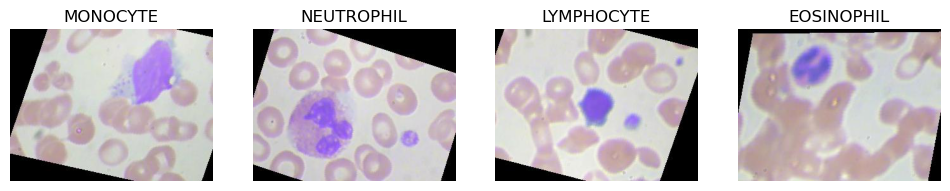

In [71]:
show_sample = []
for label in os.listdir('dataset2-master/dataset2-master/images/TRAIN/'):
    img_id = os.listdir('dataset2-master/dataset2-master/images/TRAIN/' + label)

    show_sample.append(('dataset2-master/dataset2-master/images/TRAIN/' + label + '/' + img_id[0], label))

fig, axis = plt.subplots(1, 4, figsize=(12, 3))

for sample, ax in zip(show_sample, axis.flatten()):

    img_path, label = sample
    img = plt.imread(img_path)

    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

In [72]:
path_train = './dataset2-master/dataset2-master/images/TRAIN/'
train = pd.DataFrame(columns=['img_id', 'label'])

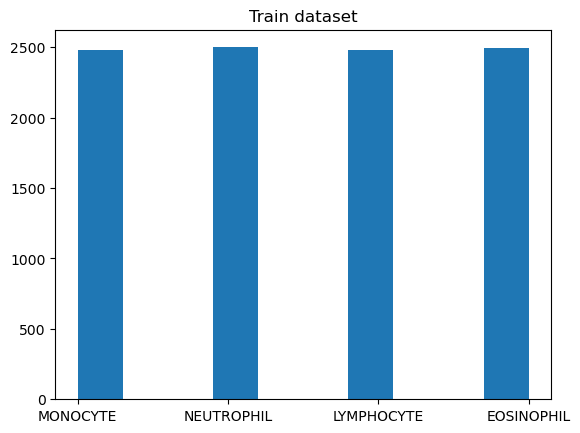

In [73]:
for label in os.listdir(path_train):
    
    img_id = os.listdir('dataset2-master/dataset2-master/images/TRAIN/' + label)
    df = pd.DataFrame(img_id, columns=['img_id'])
    df['label'] = label
    train = pd.concat([train, df])
        
        
clean_mask = train['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
train = train.loc[~clean_mask, :].reset_index(drop=True)

train.label.hist()
plt.title('Train dataset')
plt.grid(False)
plt.show()

In [74]:
path_test = './dataset2-master/dataset2-master/images/TEST/'
test = pd.DataFrame(columns=['img_id', 'label'])

for label in os.listdir(path_test):
    mg_id = os.listdir('dataset2-master/dataset2-master/images/TEST/' + label)
    df = pd.DataFrame(img_id, columns=['img_id'])
    df['label'] = label
    test = pd.concat([test, df])
    
clean_mask = test['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
test = test.loc[~clean_mask, :].reset_index(drop=True)

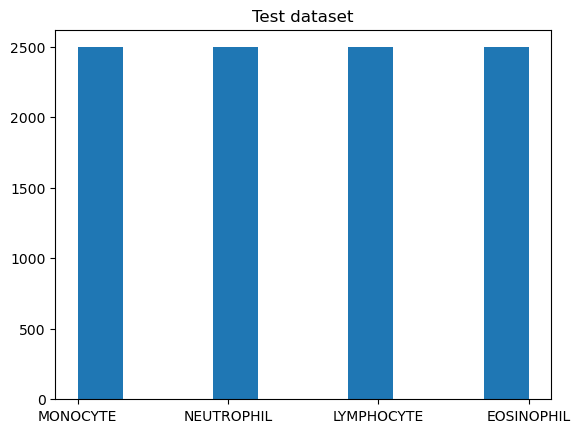

In [75]:
test.label.hist()
plt.title('Test dataset')
plt.grid(False)
plt.show()


### Metrics

In [84]:
metrics = [met for met in os.listdir('evaluation/multi_class_output') if met[-11:]=='metrics.csv']

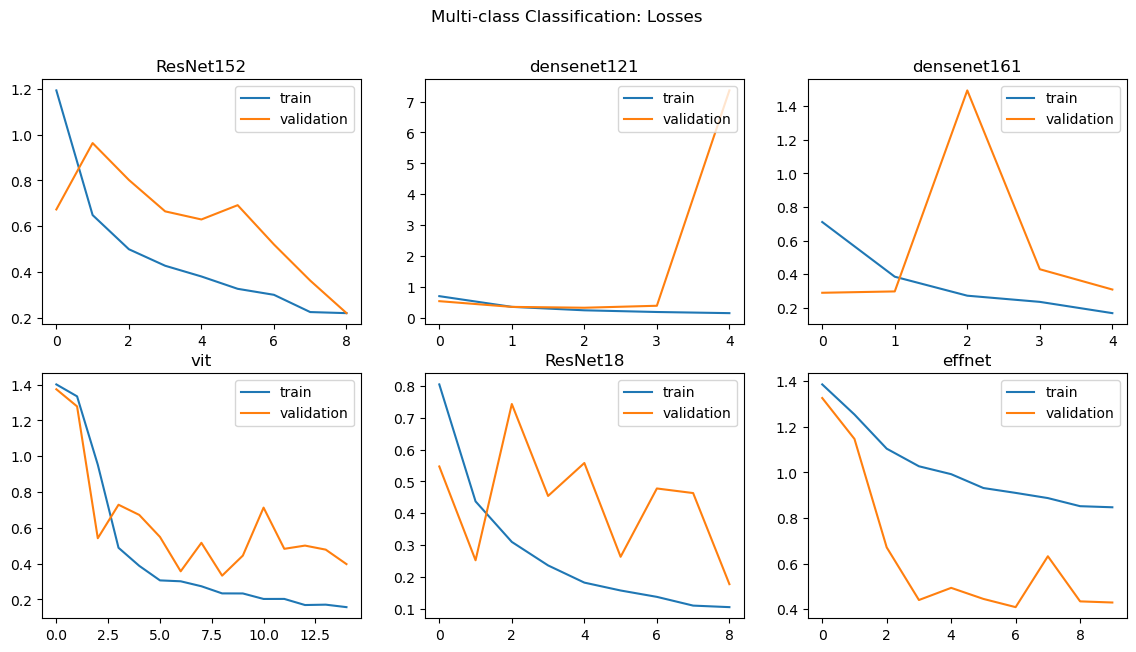

In [85]:
fig, axis = plt.subplots(2, 3, figsize=(14, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join('evaluation/multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-class Classification: Losses')
plt.savefig('classloss.png')
plt.show()

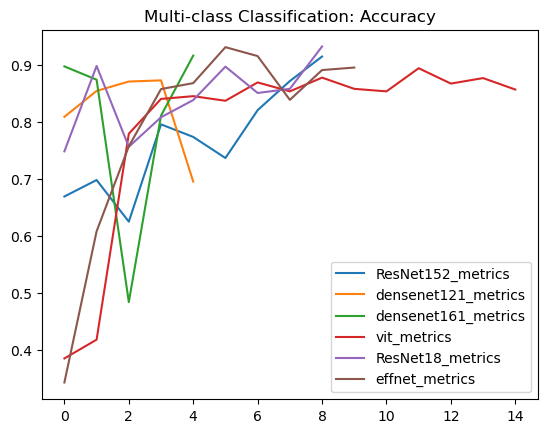

In [86]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('evaluation/multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend()
    plt.title('Multi-class Classification: Accuracy')
    
plt.savefig('classacc.png')
plt.show()

In [87]:
metrics = [met for met in os.listdir('evaluation/multi_class_output') if met[-11:]!='metrics.csv' and met[-3:]=='csv' ]

In [88]:
def eval_metrics(list_metrics, names, path='', multi_label=False):
    
    models_metrics=[]
    
    for name, metric in zip(names, list_metrics):
        
        if not multi_label:
            
            preds = pd.read_csv(path+'multi_class_output/' + metric, names=['t', 'p'], skiprows=1)
            preds = (preds['t'].values, preds['p'].values)

            accuracy = sklearn.metrics.accuracy_score(*preds)
            precis_macro = sklearn.metrics.precision_score(*preds, average='macro')
            precis_micro = sklearn.metrics.precision_score(*preds, average='micro')

            recall_macro = sklearn.metrics.recall_score(*preds, average='macro')
            recall_micro = sklearn.metrics.recall_score(*preds, average='micro')

            f1_macro = sklearn.metrics.f1_score(*preds, average='macro')
            f1_micro = sklearn.metrics.f1_score(*preds, average='micro')

            models_metrics.append([name, accuracy, 
                                   precis_macro, precis_micro, 
                                   recall_macro, recall_micro,
                                   f1_macro, f1_micro])
            columns=['model', 'accuracy', 'precision (macro)', 'precision (micro)', 
                     'recall (macro)', 'recall (micro)', 'F1 (macro)', 'F1 (micro)']
            
            
        else:
            preds = metric
            ex_r = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            hamm = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            Recall = sklearn.metrics.precision_score(*preds, average='samples') 
            Precision = sklearn.metrics.recall_score(*preds, average='samples')
            f1 = sklearn.metrics.f1_score(*preds, average='samples')
            models_metrics.append([name, ex_r, hamm, Recall, Precision, f1])
            
            columns=['model', 'Exact Match Ratio', 'Hamming loss', 'Recall', 'Precision', 'F1']


            

    models_metrics = pd.DataFrame(models_metrics, columns=columns)
    
    if not multi_label:
        models_metrics.to_csv(path+'eval_result_class.csv', index=False)
    else:
         models_metrics.to_csv(path+'eval_result_label.csv', index=False)

    return models_metrics

In [89]:
metrics = sorted(metrics)
models_name = [item.split('.')[0].lower() for item in metrics]

In [90]:
eval_metrics(metrics, models_name, path='evaluation/')

,model,accuracy,precision (macro),precision (micro),recall (macro),recall (micro),F1 (macro),F1 (micro)
0,resnet152,0.914757,0.913539,0.914757,0.914980,0.914757,0.913517,0.914757
1,resnet18,0.932449,0.936440,0.932449,0.932577,0.932449,0.932841,0.932449
2,densenet121,0.872939,0.887754,0.872939,0.872932,0.872939,0.874157,0.872939
3,densenet161,0.916365,0.917669,0.916365,0.916586,0.916365,0.915667,0.916365
4,effnet,0.931242,0.933620,0.931242,0.931398,0.931242,0.931379,0.931242
5,vit,0.894250,0.912612,0.894250,0.894179,0.894250,0.895673,0.894250


### Multi-label problem

In [13]:
data = pd.read_csv('sample_labels.csv')
data['lables'] = data['Finding Labels'].str.split('|')

labels            
No Finding            3044
Infiltration           967
Effusion               644
Atelectasis            508
Nodule                 313
Mass                   284
Pneumothorax           271
Consolidation          226
Pleural_Thickening     176
Cardiomegaly           141
Emphysema              127
Edema                  118
Fibrosis                84
Pneumonia               62
Hernia                  13
dtype: int64

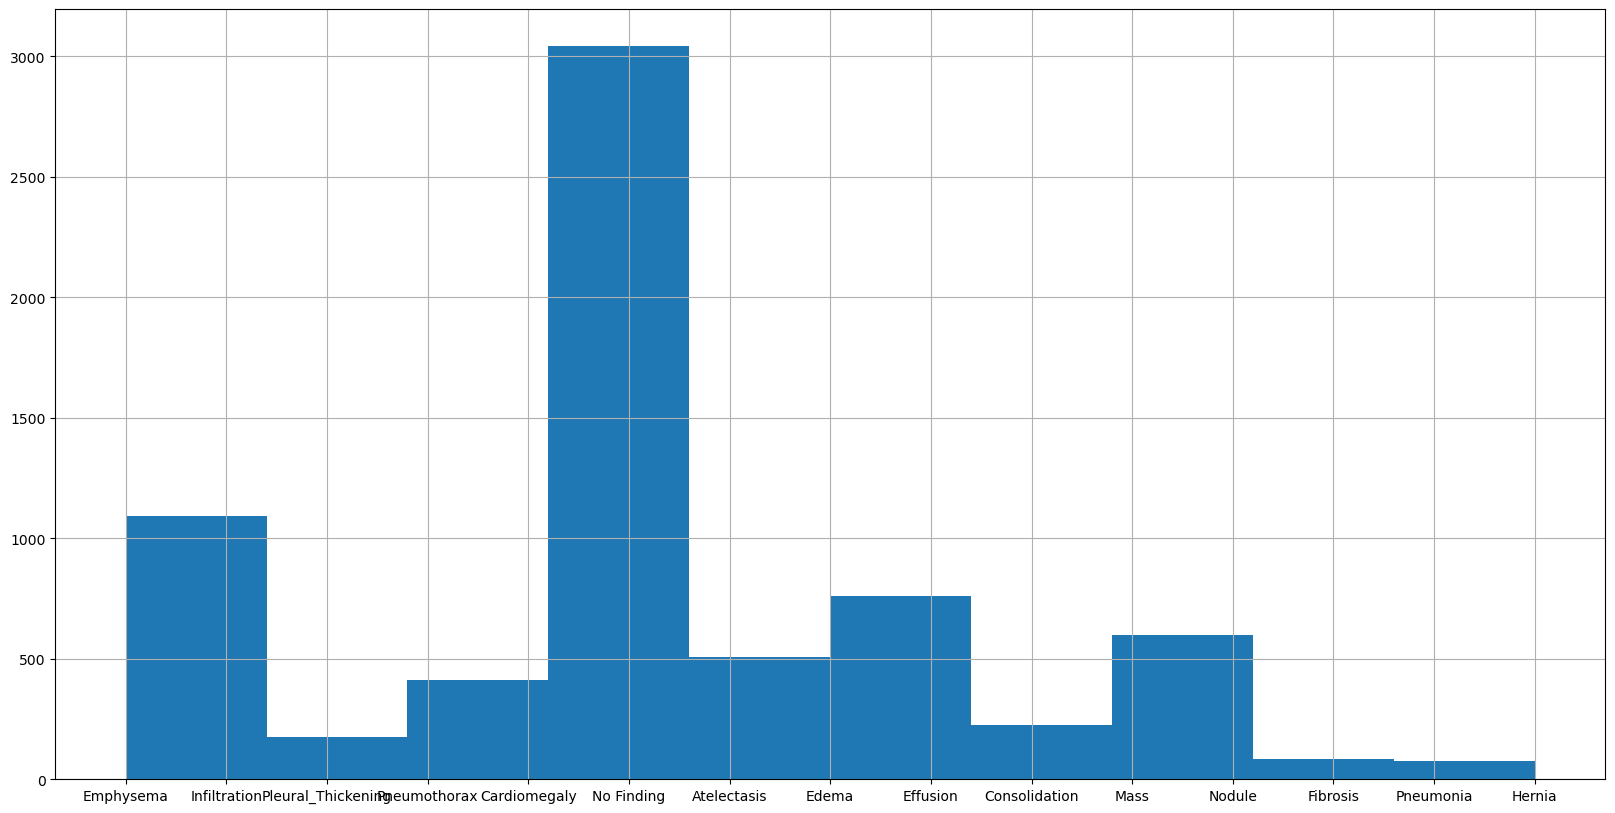

In [16]:
labels = []
for lable in data['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10))

labels.value_counts()

### Train/Test split

In [19]:
train = data.loc[:int(0.8*data.shape[0]), :]
test = data.loc[int(0.8*data.shape[0])+1:, :].reset_index(drop=True)

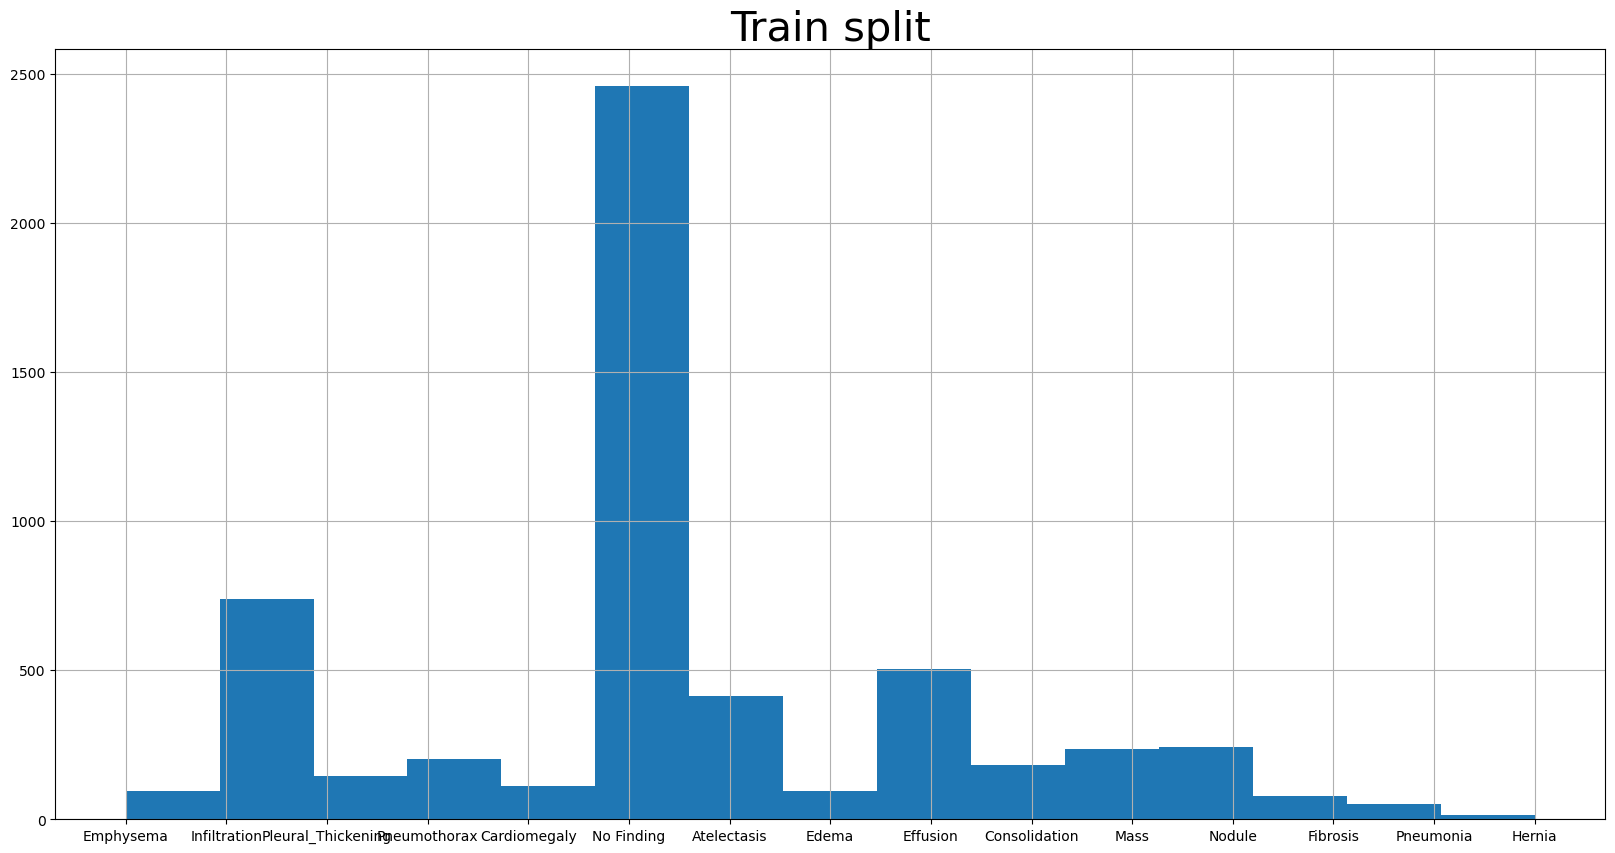

In [22]:
labels = []
for lable in train['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10), bins=15)
plt.title('Train split', fontsize=30)
plt.savefig('labtrain.png')

plt.show()

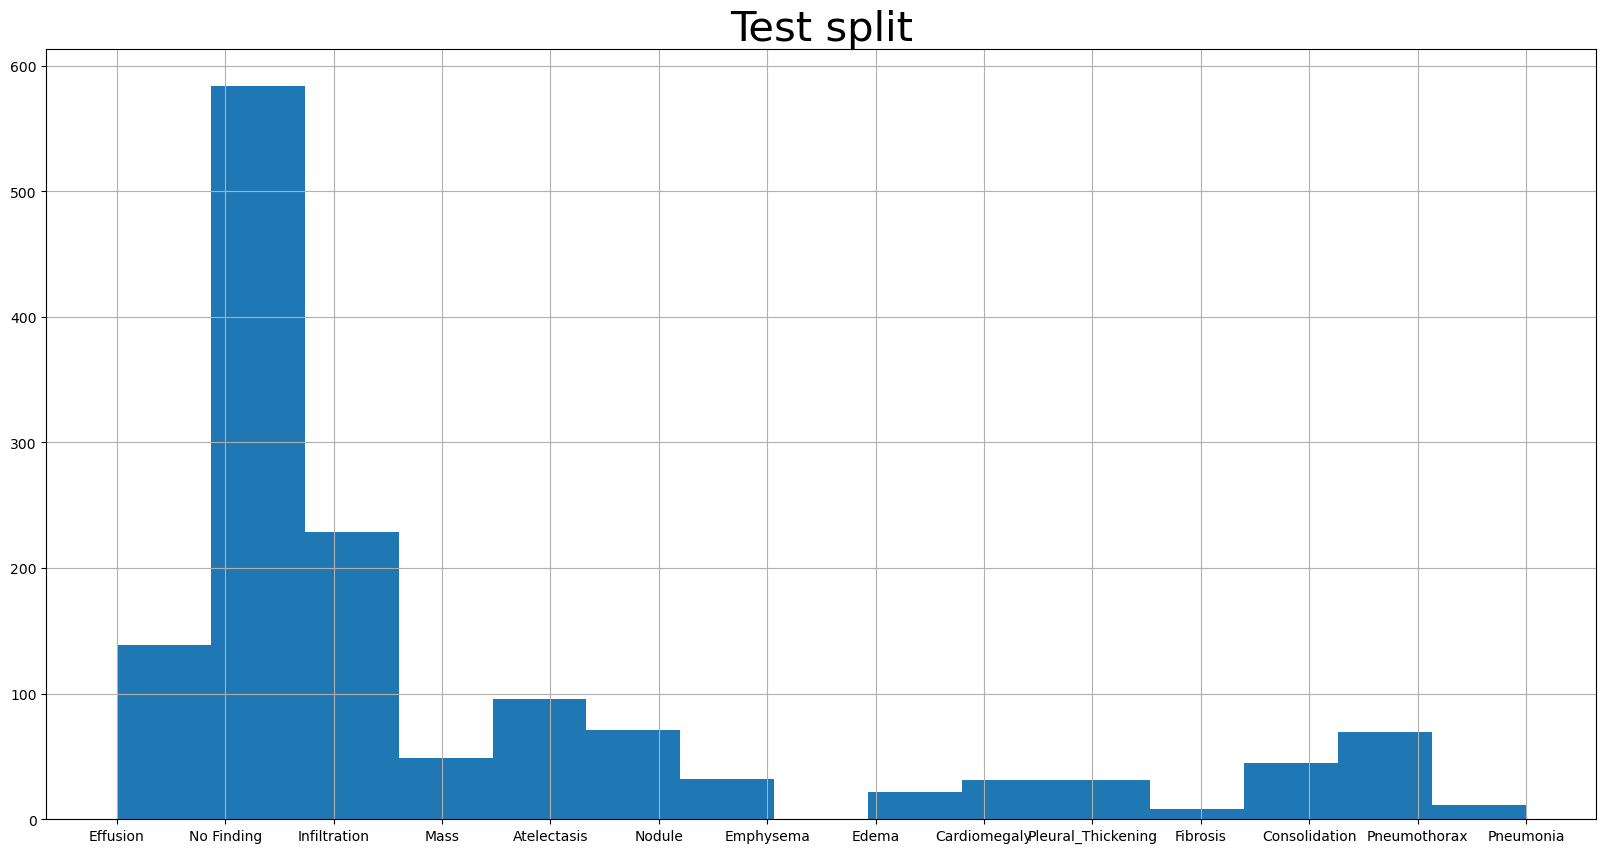

In [23]:
testlabels = []
for lable in test['lables'].values:
    testlabels.extend(lable)   
    
testlabels = pd.DataFrame(testlabels, columns=['labels'])

testlabels['labels'].hist(figsize=(20, 10), bins=15)
plt.title('Test split', fontsize=30)
plt.savefig('labtest.png')

plt.show()

In [92]:
metrics = [met for met in os.listdir('evaluation/multi_label_output') if met[-11:]=='metrics.csv']

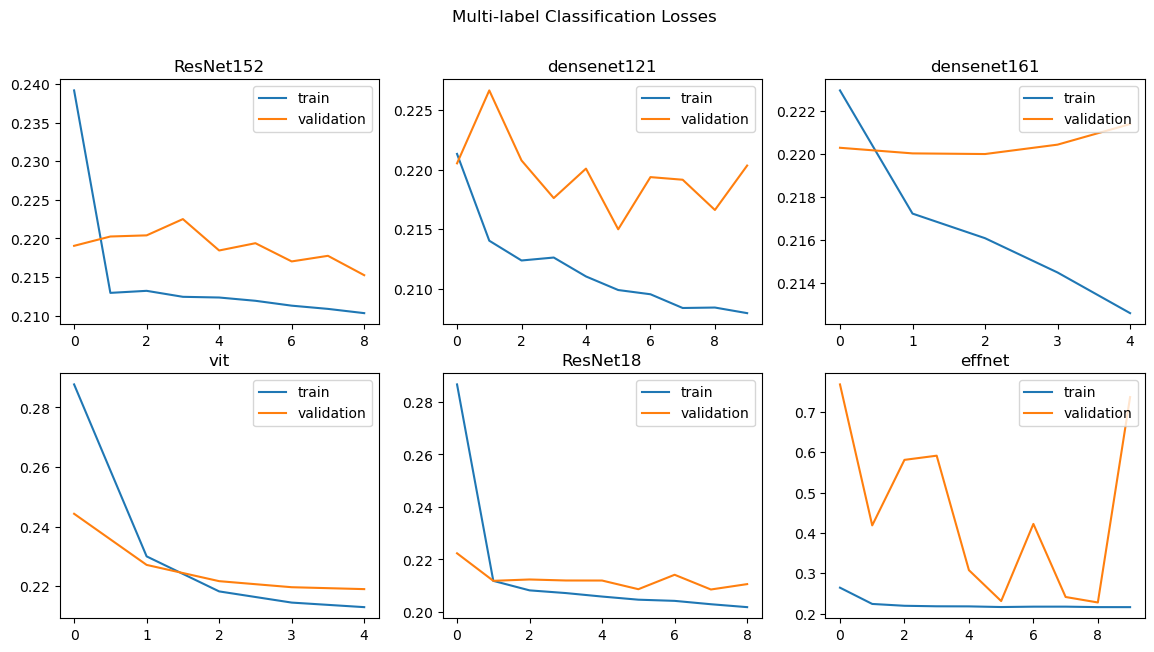

In [93]:
fig, axis = plt.subplots(2, 3, figsize=(14, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join('evaluation/multi_label_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-label Classification Losses')
plt.savefig('labloss.png')

plt.show()

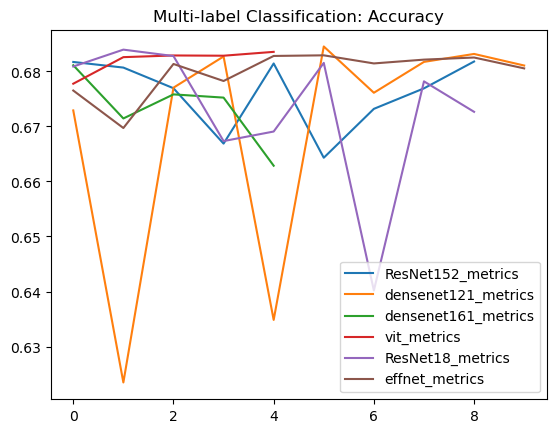

In [94]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('evaluation/multi_label_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    
plt.legend(loc="lower right")
plt.title('Multi-label Classification: Accuracy')
plt.savefig('labacc.png')
plt.show()

In [95]:
metrics = [met for met in os.listdir('evaluation/multi_label_output') if met[-11:]=='metrics.csv']

In [96]:
TRESHOLD=0.4


pred_metrics = [met for met in os.listdir('evaluation/multi_label_output') if met[:4]=='pred']
true_metrics = [met for met in os.listdir('evaluation/multi_label_output') if met[:4]=='true']


metrics = []
models_name = [item.split('.')[0][5:] for item in sorted(true_metrics)]

for true_name, pred_name in zip(sorted(true_metrics), sorted(pred_metrics)):
    true = pd.read_csv('evaluation/multi_label_output/'+ true_name).astype(int).values
    pred = pd.read_csv('evaluation/multi_label_output/'+ pred_name)
        
    pred = (pred > TRESHOLD).astype(int).values
    
    metrics.append((true, pred))
    
    
eval_metrics(metrics, models_name, multi_label=True, path='evaluation/')

,model,Exact Match Ratio,Hamming loss,Recall,Precision,F1
0,ResNet152,0.501338,0.501338,0.502230,0.501933,0.502052
1,ResNet18,0.473684,0.473684,0.476360,0.474874,0.475320
2,densenet121,0.513827,0.513827,0.513827,0.513827,0.513827
3,densenet161,0.520963,0.520963,0.520963,0.520963,0.520963
4,effnet,0.520963,0.520963,0.520963,0.520963,0.520963
5,vit,0.520963,0.520963,0.520963,0.520963,0.520963
